# An inspection of the gathered data from the `olcude` profiling experiments on the rodinia OpenCL benchmark suite

In this notebook, we are going to gather/present general info regarding our experiments using the `oclude` tool for standalone OpenCL kernel execution and profiling (see [here](https://github.com/zehanort/oclude)).

**The experiments have already taken place** (they will not be conducted in this notebook) and the results have been stored in the form of JSON data as text files. Special helper functions have been written to parse these files and turn them into Python-native dictionaries.

Please note that in this notebook, we treat all data in the same way, regardless of the kernel the execution of which produced them. This way, we hope to gain insight on the rodinia benchmark suite and the way OpenCL kernels are written and the behavior they demonstrate in general.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-collection" data-toc-modified-id="1.-Data-collection-1">1. Data collection</a></span><ul class="toc-item"><li><span><a href="#1.1-Experimental-procedure" data-toc-modified-id="1.1-Experimental-procedure-1.1">1.1 Experimental procedure</a></span></li><li><span><a href="#1.2-Kernel-profiling-general-statistics" data-toc-modified-id="1.2-Kernel-profiling-general-statistics-1.2">1.2 Kernel profiling general statistics</a></span></li></ul></li><li><span><a href="#2.-Relationship-between-the-global-NDRange-and-the-executed-instructions-(EDA)" data-toc-modified-id="2.-Relationship-between-the-global-NDRange-and-the-executed-instructions-(EDA)-2">2. Relationship between the global NDRange and the executed instructions (EDA)</a></span><ul class="toc-item"><li><span><a href="#2.1-Regarding-all-kernels" data-toc-modified-id="2.1-Regarding-all-kernels-2.1">2.1 Regarding all kernels</a></span><ul class="toc-item"><li><span><a href="#2.1.1-Averaging-instruction-counts-for-each-kernel" data-toc-modified-id="2.1.1-Averaging-instruction-counts-for-each-kernel-2.1.1">2.1.1 Averaging instruction counts for each kernel</a></span></li><li><span><a href="#2.1.2-Correlation-between-gsize-and-executed-instructions" data-toc-modified-id="2.1.2-Correlation-between-gsize-and-executed-instructions-2.1.2">2.1.2 Correlation between gsize and executed instructions</a></span></li></ul></li><li><span><a href="#2.2-Regarding-the-&quot;relatively-fast&quot;-kernels" data-toc-modified-id="2.2-Regarding-the-&quot;relatively-fast&quot;-kernels-2.2">2.2 Regarding the "relatively fast" kernels</a></span></li><li><span><a href="#2.3-Regarding-the-&quot;relatively-slow&quot;-kernels" data-toc-modified-id="2.3-Regarding-the-&quot;relatively-slow&quot;-kernels-2.3">2.3 Regarding the "relatively slow" kernels</a></span></li><li><span><a href="#2.4-Comparative-conclusions" data-toc-modified-id="2.4-Comparative-conclusions-2.4">2.4 Comparative conclusions</a></span></li><li><span><a href="#2.5-In-defence-of-the-(large)-number-of-samples-for-the-same-gsize-and-why-it-is-essential" data-toc-modified-id="2.5-In-defence-of-the-(large)-number-of-samples-for-the-same-gsize-and-why-it-is-essential-2.5">2.5 In defence of the (large) number of samples for the same gsize and why it is essential</a></span></li></ul></li></ul></div>

In [1]:
%%capture
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade pandas
!pip install --upgrade plotly
!pip install --upgrade matplotlib
!pip install --upgrade seaborn

In [2]:
### all imports in this cell ###

import os
import itertools
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sb
import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pprint import pprint

pyo.init_notebook_mode(connected=True)

%matplotlib inline

In [3]:
### some globals ###

outdir = os.path.join(os.pardir, 'desk', 'outputs')

In [4]:
# some helper functions, do not bother with them

def sorted_filenames_keyfunc(filename):
     return int(filename.split('__')[3].split('.')[0])

def get_grouped_all_profilings_filenames():
    
    def groupby_keyfunc(filename):
        return filename.split('__')[:3]

    sorted_filenames = sorted(os.listdir(outdir), key=groupby_keyfunc)

    retlist = []
    for k, v in itertools.groupby(sorted_filenames, groupby_keyfunc):
        retlist.append((k, sorted(v, key=sorted_filenames_keyfunc)))
    return retlist

def get_gsize_from_profiling_filename(filename):
    return int(filename.split('__')[-1].split('.')[0])

def get_average_instcounts_dicts(arg, discard_zeros=False):
    if isinstance(arg, list) or isinstance(arg, tuple):
        return list(map(get_average_instcounts_dicts, arg))

    from collections import Counter
    from functools import reduce
    from operator import add

    if not isinstance(arg, dict):
        arg = load_profiling_dicts(arg)

    results = arg['results']
    samples = len(results)

    if discard_zeros:
        avg_instcounts = dict(
            reduce(add, map(Counter, map(lambda x : x['instcounts'], results)))
        )
    else:
        c = Counter()
        for d in map(lambda x : x['instcounts'], results):
            c.update(d)
        avg_instcounts = dict(c)

    avg_instcounts = {
        k : int(v) // samples for k, v in avg_instcounts.items()
    }

    if 'timeit' in results[0]:
        avg_timeit = dict(
            reduce(add, map(Counter, map(lambda x : x['timeit'], results)))
        )
        avg_timeit = {
            k : v / samples for k, v in avg_timeit.items()
        }
    else:
        avg_timeit = None

    avg_dict = {}
    for k in filter(lambda x : x != 'results', arg.keys()):
        avg_dict[k] = arg[k]

    avg_dict['results'] = dict(instcounts=avg_instcounts)
    if avg_timeit:
        avg_dict['results']['timeit'] = avg_timeit

    return avg_dict

def get_list_of_profilings_filenames(benchmark=None, file=None, kernel=None):
    
    if benchmark is None:
        return os.listdir(outdir)

    profilings_filenames = list(filter(
        lambda x : x.startswith('__'.join(benchmark, file, kernel)),
        os.listdir(outdir)
    ))
    
    return list(map(lambda x : os.path.join(outdir, x), profilings_filenames))

def get_sorted_list_of_profilings_filenames(benchmark=None, file=None, kernel=None):
    return sorted(
        get_list_of_profilings_filenames(benchmark, file, kernel),
        key=sorted_filenames_keyfunc
    )

def load_profiling_dicts(arg, append_gsize=True):
    if isinstance(arg, list) or isinstance(arg, tuple):
        return list(map(load_profiling_dicts, arg))

    from json import load
    with open(os.path.join(outdir, arg), 'r') as f:
        profiling_dict = load(f)

    if append_gsize:
        profiling_dict['gsize'] = get_gsize_from_profiling_filename(arg)

    return profiling_dict

def remove_zeros(df):
    return df.loc[:, (df != 0).any(axis=0)]

def average_correlation_heatmap(dfs):
    corrs = [df.corr() for df in dfs]
    average_corrs = corrs[0].fillna(0)
    ns = np.zeros_like(average_corrs)
    ns += (~corrs[0].isna())
    for corr in corrs[1:]:
        corr_no_nan = corr.fillna(0)
        average_corrs += corr_no_nan
        ns += (~corr.isna())
    average_corrs /= ns

    mask = np.triu(np.ones_like(average_corrs, dtype=np.bool))

    f, ax = plt.subplots(figsize=(30, 20))

    sb.heatmap(
        average_corrs, annot=False, mask=mask, cmap='magma', center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}
    )
    plt.show()
    
    return average_corrs

def multi_table(table_list):
    '''
    Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

def plot_2_instructions_multiple_kernels(info, dfs, figsize, INSTR_LEFT, INSTR_RIGHT):

    n_kernels = len(dfs)
    fig, big_axes = plt.subplots(n_kernels, 1, figsize=figsize, sharey=True)

    for i, (kernel_info, big_ax) in enumerate(zip(info, big_axes)):
        big_ax.set_title(
            f'Benchmark: {kernel_info[0]}, File: {kernel_info[1]}, Kernel: {kernel_info[2]}',
            fontsize=24
        )
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax._frameon = False

    for i in range(2 * n_kernels):
        ax = fig.add_subplot(n_kernels, 2, i + 1)
        ax.set_xlabel('gsize', fontsize=16)
        curr_df = dfs[i//2]
        if i % 2 == 0:
            ax.plot(curr_df['gsize'], curr_df[INSTR_LEFT])
            ax.set_ylabel(INSTR_LEFT, fontsize=16)
        else:
            ax.plot(curr_df['gsize'], curr_df[INSTR_RIGHT])
            ax.set_ylabel(INSTR_RIGHT, fontsize=16)

    fig.set_facecolor('w')
    plt.tight_layout()
    plt.show()

## 1. Data collection

### 1.1 Experimental procedure

Each kernel from the rodinia benchmark suite was treated separately, even those that were in the same file.

From these, some could not be profiled with `oclude` due to frequent segmentation faults, which most probably were caused by the numerical values of the input buffers. At this point, it should be reminded that `oclude` initializes the kernel arguments in a random way, taking into consideration the argument type only (e.g. it will never initialize an unsigned type with a value below zero). An OpenCL kernel, though, may rely on the input data meeting certain requirements, either regarding the numerical values of the input or even the buffer sizes. For example, a kernel may take for granted that its first argument has twice the size of the second. It is obvious that, in such a case, segmentation faults are to be expected and `oclude`, in its current development status, can not do anything about them.

From the kernels that *could* be profiled (i.e. their execution did not lead to -frequent- segfaults), a number of profiling samples was taken. More precisely:
- First of all, the number of samples (flag `-s/--samples`) was kept constant and equal to 100 for all experiments described in this section.
- The only variable of the profiling experiments was the global NDRange (flag `-g/--gsize`). The local NDRange was not defined, which means that it was automatically and (nearly) optimally selected by the OpenCL runtime.
- All kernels were profiled for global sizes starting from 100 and upwards, with a step of 50. The profiling process was terminated in case the 100 samples took longer than 3 seconds to run (flag `-x/--timeout`) or the size reached a value of 100000. Only the former happened.
- Some kernels were too slow to get 100 samples in less than 3 seconds for a global NDRange greater than 100, or we managed to get only a single digit number of 100-samples profilings. For these kernels (labeled "relatively slow"), the range from 10 to 100 was used regarding the global NDRange, with a step of 5. All the other kernels are labeled "relatively fast".
- The values of the global NDRange and the timeout flags were manually fine-tuned when needed, in order to be certain that at least 20 100-samples profilings were successfully acquired from each kernel.
- Each profiling corresponds to a dictionary, the return value of the `profile_opencl_kernel` function of `oclude`. Every such profiling was stored as a JSON file for subsequent processing.

### 1.2 Kernel profiling general statistics

A pie chart showing the behavior of the rodinia OpenCL kernels during our experiments follows. You can hover your mouse over the pie chart to learn the absolute values.

In [5]:
all_kernels = 58 # I just counted them :)

# either kernels that constantly end up segfaulting
# or kernels that can not be randomly profiled
segfault_kernels = 12
unprofilable_kernels = segfault_kernels + 7

# regarding profiled kernels
profiling_filenames = get_grouped_all_profilings_filenames()
relatively_slow_kernels = 0
relatively_fast_kernels = 0
for _, kernel_profiling_files in profiling_filenames:
    smallest_gsize = get_gsize_from_profiling_filename(kernel_profiling_files[0])
    if smallest_gsize <= 10:
        relatively_slow_kernels += 1
    else:
        relatively_fast_kernels += 1

# plot above info

labels = 'relatively fast', 'relatively slow', '"unprofilable"'
values = relatively_fast_kernels, relatively_slow_kernels, unprofilable_kernels
colors = 'green', 'orange', 'red'

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    marker=dict(colors=colors)
)])

fig.update_layout(
    title=dict(
        text='"Profilability" of rodinia OpenCL kernels',
        font=dict(
            family='Courier New, monospace',
            size=22
        ),
        x=.5
    ),
    font=dict(
        family='Courier New, monospace',
        size=12
    )
)
fig.show()

We can see that the vast majority (43.1%) of the kernels are relatively fast, meaning that we managed to perform tens or even hundreds of 100-samples profiling experiments on them. They represent the majority of the rodinia benchmark suite and, as we will see later, the execution time and instructions tend to have a relatively linear relation to the global NDRange size in these kernels.

More specifically, the following table shows how many 100-sample profilings were performed on each kernel. Note that the data below refer to the "profilable" (i.e. "relatively fast" and "relatively slow") kernels, not the "unprofilable" ones.

In [6]:
all_profiling_filenames = get_grouped_all_profilings_filenames()

columns = [
    'rodinia benchmark', 'benchmark file', 'kernel name',
    '# profilings', 'smallest gsize', 'largest gsize'
]
data = [
    k + [len(v), get_gsize_from_profiling_filename(v[0]), get_gsize_from_profiling_filename(v[-1])]
    for k, v in all_profiling_filenames
]

profiling_general_info_df = pd.DataFrame(
    data=data,
    columns=columns
)
profiling_general_info_df.index += 1
profiling_general_info_df

rodinia benchmark             benchmark file               kernel name  \
1             b+tree       kernel_gpu_opencl.cl                     findK   
2             b+tree     kernel_gpu_opencl_2.cl                findRangeK   
3           backprop         backprop_kernel.cl   bpnn_adjust_weights_ocl   
4           backprop         backprop_kernel.cl     bpnn_layerforward_ocl   
5                bfs                 Kernels.cl                     BFS_1   
6                bfs                 Kernels.cl                     BFS_2   
7              dwt2d                 com_dwt.cl      c_CopySrcToComponent   
8              dwt2d                 com_dwt.cl     c_CopySrcToComponents   
9           gaussian    gaussianElim_kernels.cl                      Fan1   
10          gaussian    gaussianElim_kernels.cl                      Fan2   
11         heartwall       kernel_gpu_opencl.cl         kernel_gpu_opencl   
12           hotspot          hotspot_kernel.cl                   hotspot   
13         hotspot3D           hotspotKernel.cl               hotspotOpt1   
14        hybridsort      bucketsort_kernels.cl        bucketprefixoffset   
15        hybridsort      bucketsort_kernels.cl                bucketsort   
16        hybridsort           histogram1024.cl       histogram1024Kernel   
17        hybridsort               mergesort.cl            mergeSortFirst   
18            kmeans                  kmeans.cl           kmeans_kernel_c   
19            kmeans                  kmeans.cl               kmeans_swap   
20               lud              lud_kernel.cl              lud_internal   
21           myocyte       kernel_gpu_opencl.cl         kernel_gpu_opencl   
22                nn  nearestNeighbor_kernel.cl           NearestNeighbor   
23    particlefilter         particle_double.cl         find_index_kernel   
24    particlefilter         particle_double.cl         likelihood_kernel   
25    particlefilter         particle_double.cl  normalize_weights_kernel   
26    particlefilter         particle_double.cl                sum_kernel   
27    particlefilter          particle_naive.cl           particle_kernel   
28    particlefilter         particle_single.cl         find_index_kernel   
29    particlefilter         particle_single.cl         likelihood_kernel   
30    particlefilter         particle_single.cl  normalize_weights_kernel   
31    particlefilter         particle_single.cl                sum_kernel   
32        pathfinder                 kernels.cl            dynproc_kernel   
33              srad       kernel_gpu_opencl.cl           compress_kernel   
34              srad       kernel_gpu_opencl.cl            extract_kernel   
35              srad       kernel_gpu_opencl.cl            prepare_kernel   
36              srad       kernel_gpu_opencl.cl             reduce_kernel   
37              srad       kernel_gpu_opencl.cl              srad2_kernel   
38              srad       kernel_gpu_opencl.cl               srad_kernel   
39     streamcluster                 Kernels.cl             memset_kernel   

    # profilings  smallest gsize  largest gsize  
1             39              10            200  
2             21              10            110  
3            382             100          19150  
4             50             100           2550  
5            178              10            895  
6            894             100          44750  
7            550             100          27550  
8            573             100          28700  
9            903             100          45200  
10           623             100          31200  
11            33              10            170  
12            44              10            225  
13            49              10            250  
14           123              10            620  
15            77             100           3900  
16            20               5            100  
17           288             100           6350  
18            22      

We can observe that another way of differentiating between "relatively fast" and "relatively slow" kernels is that the former are the ones the largest global NDRange size of which is greater that 1000, while the latter are the ones the smallest global NDRange size of which is smaller than 100:

In [7]:
print('"Relatively fast" kernels:',
      len(profiling_general_info_df[profiling_general_info_df['largest gsize'] > 1000]))
print('"Relatively slow" kernels:',
      len(profiling_general_info_df[profiling_general_info_df['smallest gsize'] < 100]))

"Relatively fast" kernels: 25
"Relatively slow" kernels: 14


## 2. Relationship between the global NDRange and the executed instructions (EDA)

We are now ready to investigate the relationship between the global NDRange size (henceforth gsize) and the instructions executed from an OpenCL kernel. To achieve this, we are going to use the data we acquired with the help of `oclude`.

It is reminded that each of the profilings of the kernels refers to a single gsize value and consists of 100 samples, taken with different random initialization of the kernel input data (i.e. the value(s) of its arguments). In that way, we are able to:
1. inspect a single execution of a specific kernel for a specific gsize, or
2. inspect the 100-samples profiling as a whole (e.g. by taking the average instructions that were executed), in order to smooth out the effects of randomness regarding the arguments initialization and/or to study how "predictable" or "well-behaved" the kernel is, in terms of the variance of the instructions executed for the same gsize.

We will focus on the second approach.

### 2.1 Regarding all kernels

In this section, we will work on all kernels and start gaining some insight on what is going on. For this section, we will work with the *average* executed instructions for each profiling and not for each one of the 100 measurements separately.

#### 2.1.1 Averaging instruction counts for each kernel

First of all, we will take the average instruction counts from all of the profilings we performed. We will create a list of DataFrames. Each one will correspond to a kernel and will contain the averaged executed instructions per gsize for this kernel.

In [8]:
# get the profiling files per kernel
grouped_profilings_filenames = get_grouped_all_profilings_filenames()

# load the dicts for all profilings
prof_dicts = [
    (k, load_profiling_dicts(v))
    for k, v in grouped_profilings_filenames
]

# calculate the average instcounts for all profilings
averaged_prof_dicts = [
    (k, get_average_instcounts_dicts(v))
    for k, v in prof_dicts
]

Now, we will create a DataFrame for each kernel, which will contain all the averaged instruction counts for every gsize value:

In [9]:
llvm_instructions = list(averaged_prof_dicts[0][1][0]['results']['instcounts'].keys())

averaged_prof_dfs = []
for kernel_info, prof_info in averaged_prof_dicts:
    df = pd.DataFrame(columns=['gsize'] + llvm_instructions, dtype=int)
    for i, sample in enumerate(prof_info):
        df.loc[i] = [sample['gsize']] + list(sample['results']['instcounts'].values())
    averaged_prof_dfs.append(df)

Here is an example DataFrame for a random kernel:

In [10]:
averaged_prof_dfs[24]

gsize   add   sub  mul  udiv  sdiv  urem  srem  fneg  fadd  ...  \
0      100    31    30    1     0     0     0     1     0    60  ...   
1      150    37    36    1     0     0     0     1     0    73  ...   
2      200    51    50    1     0     0     0     1     0   100  ...   
3      250    80    79    1     0     0     0     1     0   160  ...   
4      300    64    63    1     0     0     0     1     0   128  ...   
..     ...   ...   ...  ...   ...   ...   ...   ...   ...   ...  ...   
178   9000  2412  2411    1     0     0     0     1     0  4823  ...   
179   9050  2928  2927    1     0     0     0     1     0  5856  ...   
180   9100  2604  2603    1     0     0     0     1     0  5207  ...   
181   9150  2384  2383    1     0     0     0     1     0  4766  ...   
182   9200  2308  2307    1     0     0     0     1     0  4616  ...   

     addrspacecast   icmp  fcmp  phi  select  freeze  va_arg  landingpad  \
0                0    531     0    0       0       0       0           0   
1                0    787     0    0       0       0       0           0   
2                0   1051     0    0       0       0       0           0   
3                0   1330     0    0       0       0       0           0   
4                0   1564     0    0       0       0       0           0   
..             ...    ...   ...  ...     ...     ...     ...         ...   
178              0  47412     0    0       0       0       0           0   
179              0  48178     0    0       0       0       0           0   
180              0  48104     0    0       0       0       0           0   
181              0  48134     0    0       0       0       0           0   
182              0  48308     0    0       0       0       0           0   

     catchpad  cleanuppad  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  
..        ...         ...  
178         0           0  
179         0           0  
180         0           0  
181         0           0  
182         0           0  

[183 rows x 74 columns]

#### 2.1.2 Correlation between gsize and executed instructions

We are now ready to measure the correlation between the gsize parameter and the executed instructions. This is a very valuable insight, because it will let us know:

1. whether the executed instructions (our dependent variables) are correlated with the gsize (our independent variable)
2. whether the executed instructions (our dependent variables) are correlated with each other

It is easy to do so for a single kernel (by calculating the correlation matrix of the the respective DataFrame), but it is not obvious how to gain an insight regarding *the whole benchmark suite*. To be more specific, it is easy to answer the following question:

> How is instruction X correlated with instruction Y in kernel K?

But it is not obvious how to answer the (much more interesting) question?

> How is instruction X correlated with instruction Y *across all kernels*?

To answer that, we will plot the **average correlation matrix** across all kernels. More specifically:
1. We will compute the correlation matrices for every kernel
2. We will take the average of these matrices

In this way, we will learn how each instruction is correlated with every other instruction across all kernels *in average*.

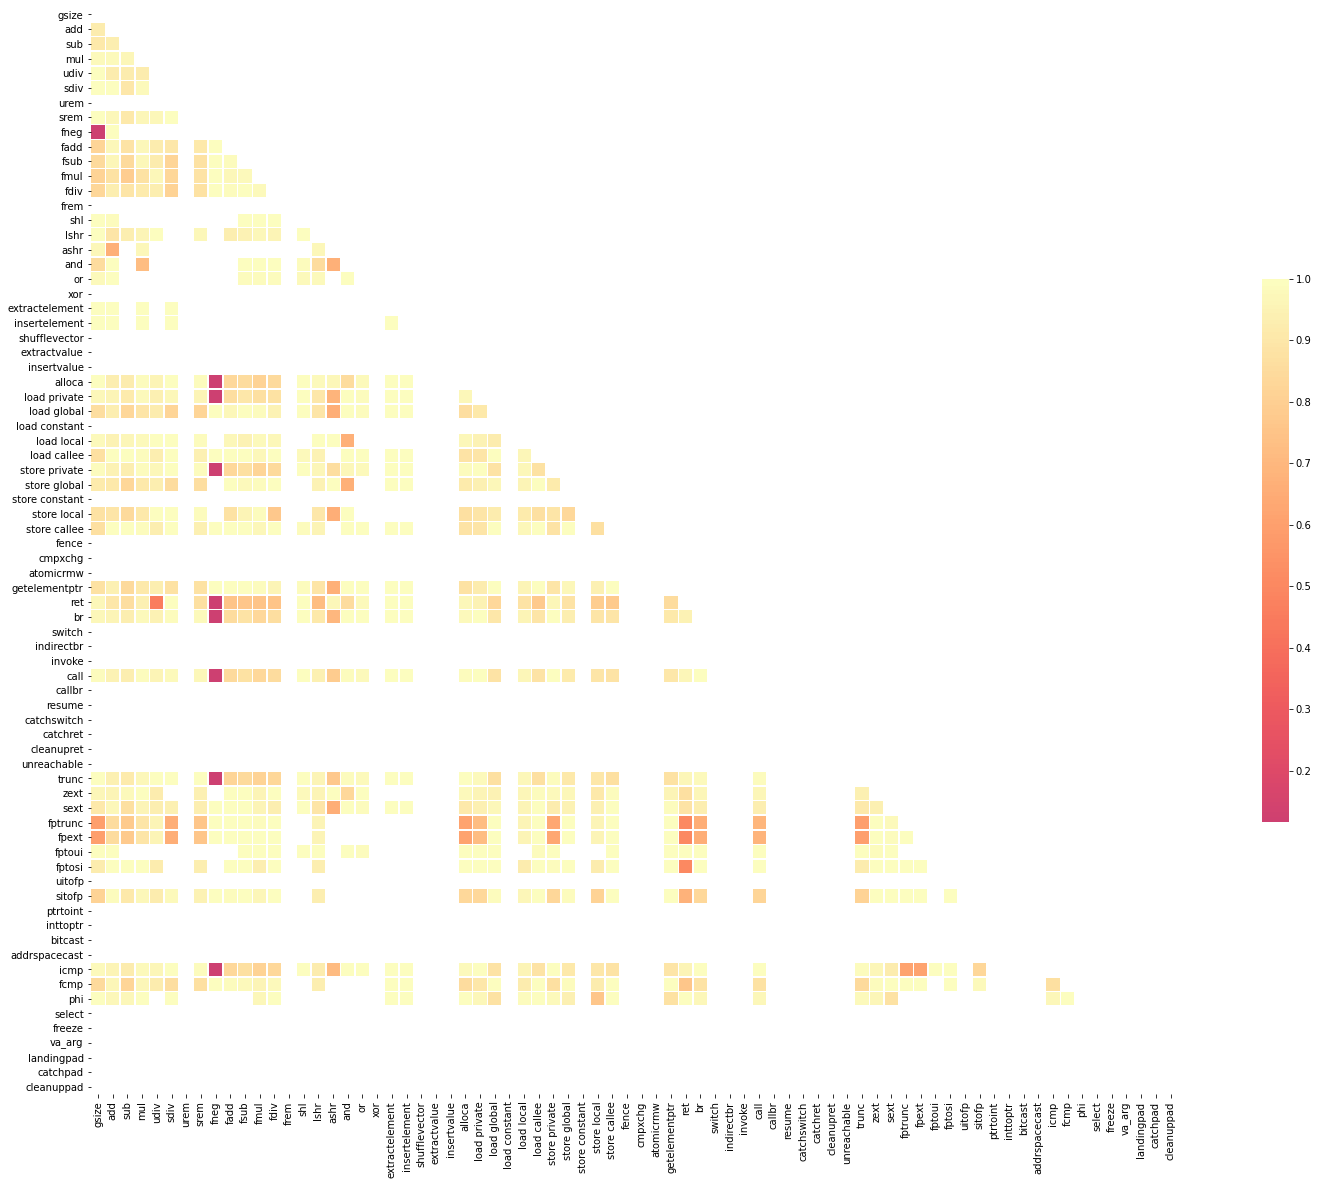

In [11]:
average_corrs = average_correlation_heatmap(averaged_prof_dfs)

From the above heatmap, it is clear that:

1. the executed instructions (our dependent variables) are **strongly correlated** with the gsize (our independent variable)
2. the executed instructions (our dependent variables) are **strongly correlated** with each other

These are great news indeed, because we are led to the following conclusions:

1. The strong correlation between the executed instructions and the gsize means that we can expect to be able to predict executed instructions given the gsize fairly accurately.
2. The strong correlation between the executed instructions means that there are groups of "similarly escalating" instruction counts (e.g. groups that are scaling linearly, squarely etc).

Combining the above, we can draw even more interesting conclusions regarding the groups of "similarly escalating" instruction counts. For example, if such a group correlates strongly with gsize, we can safely assume that the instructions of this group scale linearly, given that gsize scales linearly.

For now, we will study the correlation between the executed instructions and gsize only, because we want to focus on our main goal which is to predict instruction counts given a gsize.

A list of the correlation of the instruction counts and gsize follows, in descending strength, along with the number of kernels in which they have appeared:

In [12]:
corrs_w_gsize = average_corrs['gsize'].dropna()

existent_instructions = [x for x in llvm_instructions if x in corrs_w_gsize]
indexes = ['# kernels', 'correlation with gsize']

instr_freq_df = pd.DataFrame(columns=existent_instructions, index=indexes)

for instr in existent_instructions:
    n_kernels = 0
    for kernel_df in averaged_prof_dfs:
        # correlation of instr with gsize
        corr_w_gsize = corrs_w_gsize[instr]
        # number of kernels it appears in
        n_kernels += int((kernel_df[instr] > 0).any())
    instr_freq_df[instr] = [n_kernels, corr_w_gsize]

instr_freq_df = instr_freq_df.transpose()

print('Left: sorted by number of kernels first')
print('Right: sorted by correlation with gsize first')

multi_table([
    instr_freq_df.sort_values(indexes, ascending=False),
    instr_freq_df.sort_values(indexes[::-1], ascending=False)
])

Left: sorted by number of kernels first
Right: sorted by correlation with gsize first


We observe that all the instructions that appear in multiple kernels (i.e. they are of greater significance to us) are strongly correlated with gsize. We obviously do not need to worry about instructions like `fptrunc`, `fpext` and `fneg` which have quite weaker correlations with gsize (especially the later), given that they appear in 4, 4 and 1 kernel respectively, and thus are insignificant for our analysis.

### 2.2 Regarding the "relatively fast" kernels

We will continue with the "relatively fast" kernels. We believe that their fastness will be seen in the EDA that will follow in terms of a linear relationship between the gsize (independent variable) and the executed instructions (dependent variables).

First of all, we are going to split our DataFrames into 2 sets, consisting of the ones that correspond to the "relatively fast" kernels and of the ones that correspond to the "relatively slow" kernels.

In [13]:
relatively_fast_info, relatively_slow_info = [], []
relatively_fast_dfs, relatively_slow_dfs = [], []

for i, df in enumerate(averaged_prof_dfs):
    prof_info = profiling_general_info_df.iloc[i]
    if prof_info['largest gsize'] > 1000:
        relatively_fast_info.append(
            (prof_info['rodinia benchmark'], prof_info['benchmark file'], prof_info['kernel name'])
        )
        relatively_fast_dfs.append(df)
    elif prof_info['smallest gsize'] < 100:
        relatively_slow_info.append(
            (prof_info['rodinia benchmark'], prof_info['benchmark file'], prof_info['kernel name'])
        )
        relatively_slow_dfs.append(df)

print('"relatively fast" dfs:', len(relatively_fast_dfs))
print('"relatively slow" dfs:', len(relatively_slow_dfs))

"relatively fast" dfs: 25
"relatively slow" dfs: 14


Let's see the average correlation again, but regarding the "relatively fast" kernels only:

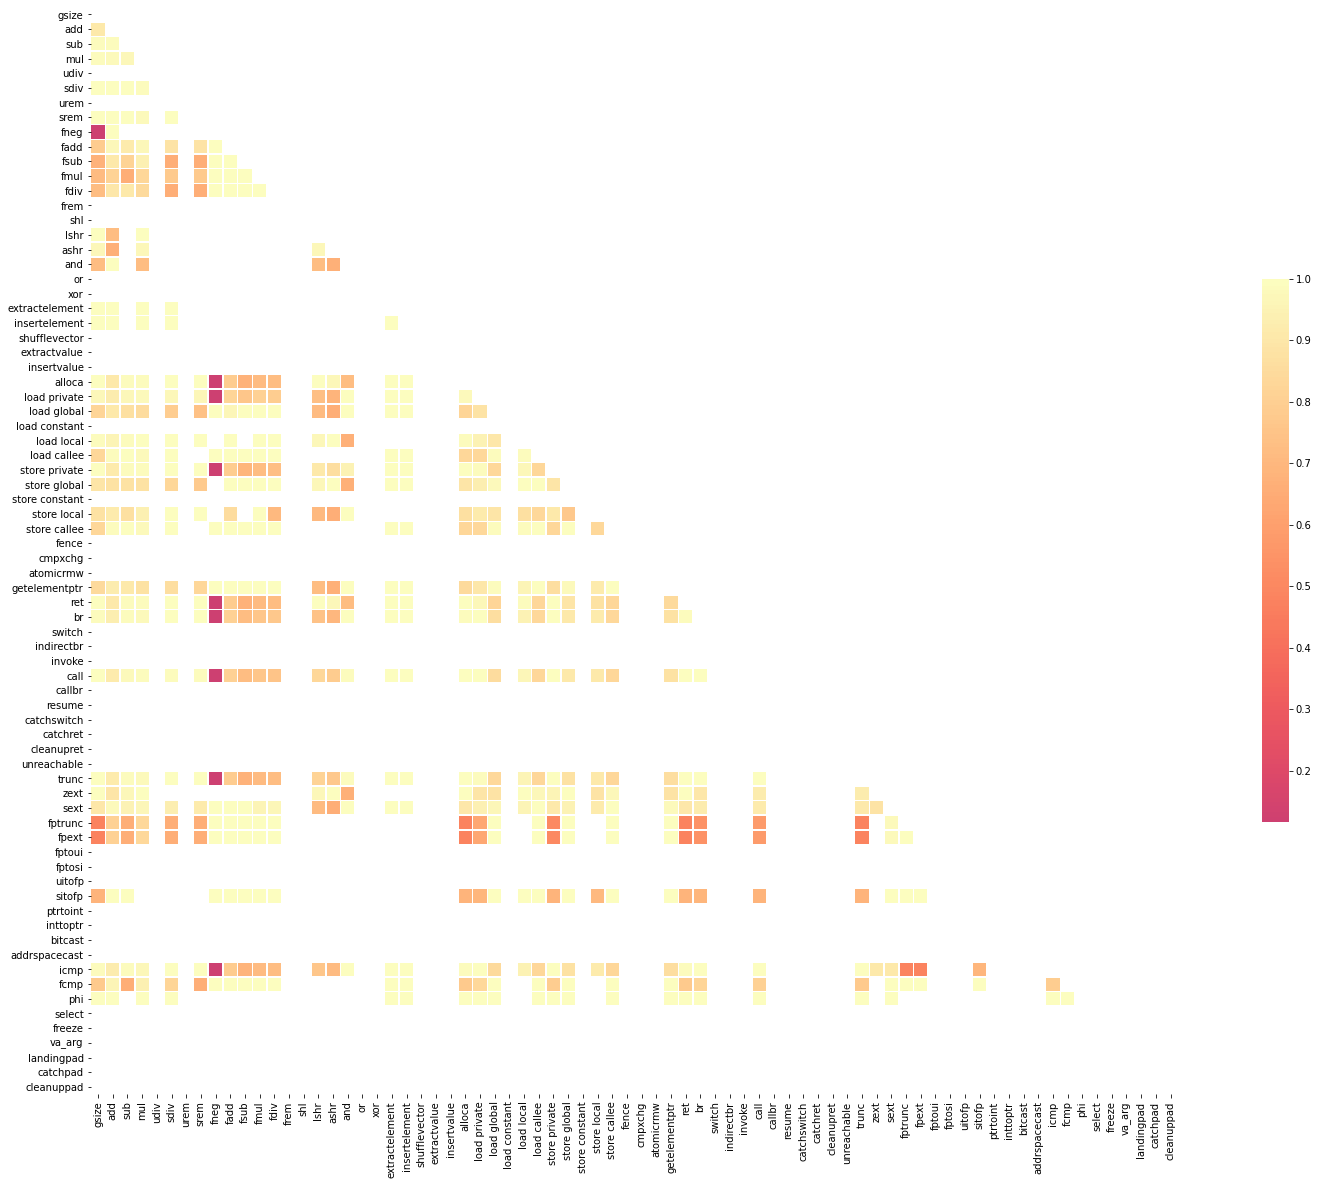

In [14]:
_ = average_correlation_heatmap(relatively_fast_dfs)

Obviously excluding the `fneg` instruction, as well as the `fptrunc` and `fpext` instructions (which tend not to scale at all and rather stay constant in the kernels in which they exist), every other correlation between gsize and the executed instructions and between the executed instructions themselves is generally strong.

It is time to plot some of the instructions against gsize. For the sake of brevity, we will plot only the following instructions:

1. `store global`: It correlates extremely strongly with every other instruction and is very important in our analysis, given that accesses to the global OpenCL memory address space are one of the most expensive operations in terms of execution time.
2. `br`: It is one of the possible instructions we can use -along `call` and `ret`- to study branching, another expensive operation. Obviously, `call` and `ret` correlate extremely strongly, given that whenever the former happened, the later must follow. We can see from the heatmap above that `call`, `ret` and `br` form one of the many strongly correlated groups of instruction counts. Furthermore, it can be shown that `call` and `ret` are **absolutely linear functions of gsize** (the corresponding diagrams are omitted for brevity). Therefore, `br` is "more interesting" than `call` and `ret` at this point in our analysis. 

We will plot `store global` and `br` for each "relatively fast" kernel.

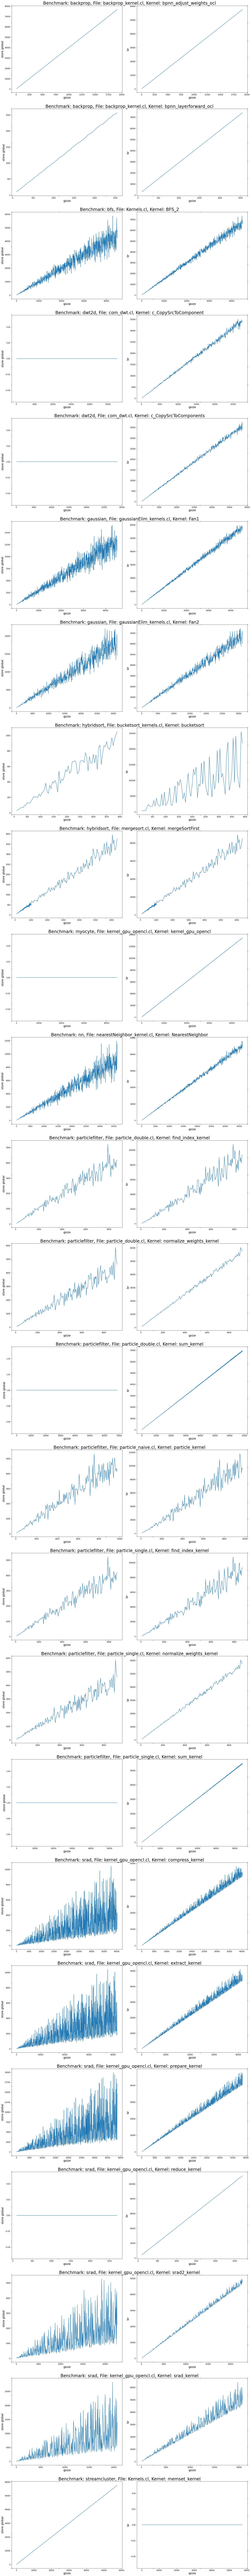

In [15]:
plot_2_instructions_multiple_kernels(
    relatively_fast_info, relatively_fast_dfs, (20, 200),
    'store global', 'br'
)

The first observation we can make is that `store global` and `ret` are **near-linear or linear functions of `gsize`**. This is an extremely important observation regarding the construction of regression models later; it may mean that we need to focus on linear models only.

With a cooler approach, we have to record the following observations:

1. In some kernels, `store global` and/or `br` have **zero counts**.
    
 1. Regarding `store global`, this may seem odd; what is the utility of an OpenCL kernel if it does not write data somewhere where the hostcode can retrieve them? It turns out, however, that some of them, e.g. the `dwt2d` kernels, are actually helper functions for other kernels, while others like the `myocyte` kernel use other helper functions to write to their global buffers. The store operations associated with the later behavior are categorized as `store callee`, because `oclude` can not infer the OpenCL address space of a memory operation when it occurs outside of a kernel function. Every kernel that exhibits this behavior belong to one of the two categories mentioned above.

 2. Regarding `br`, only the `streamcluster` kernel does not record any, and this is because it actually does not include any branching. This is easily deduced by looking at its the source code:
```c
__kernel void memset_kernel(__global char * mem_d, short val, int number_bytes){
            const int thread_id = get_global_id(0);
	        mem_d[thread_id] = val;
}
```

2. There are relations that are **absolutely linear**. In fact, all relations seem to be linear, **with more or less noise**.

3. The `srad` benchmark exhibits some **worrying behavior** regarding the relation between the executed instructions we plotted and gsize. More specifically, it also follows a linear-like trend by tends to spike a lot. Could this behavior be more generalized than it seems here? How can such relations be regressed and predicted?

We will keep in mind all of the above observations when we move to the design and selection of our regression models, and we will see if similar conclusions are drawn from the "relatively slow" kernels.

### 2.3 Regarding the "relatively slow" kernels

We will continue with the "relatively slow" kernels, and we will hope to be able to interpret their relative slowness, which led to less profilings and/or of smaller gsizes compared to the "relatively fast" ones. We believe that their slowness will be seen in the EDA that will follow in terms of a superlinear relationship between the gsize (independent variable) and the executed instructions (dependent variables).

We will start by following the same process as with the "relatively fast" kernels. Firstly, let's see the average correlation again, but regarding the "relatively slow" kernels only:

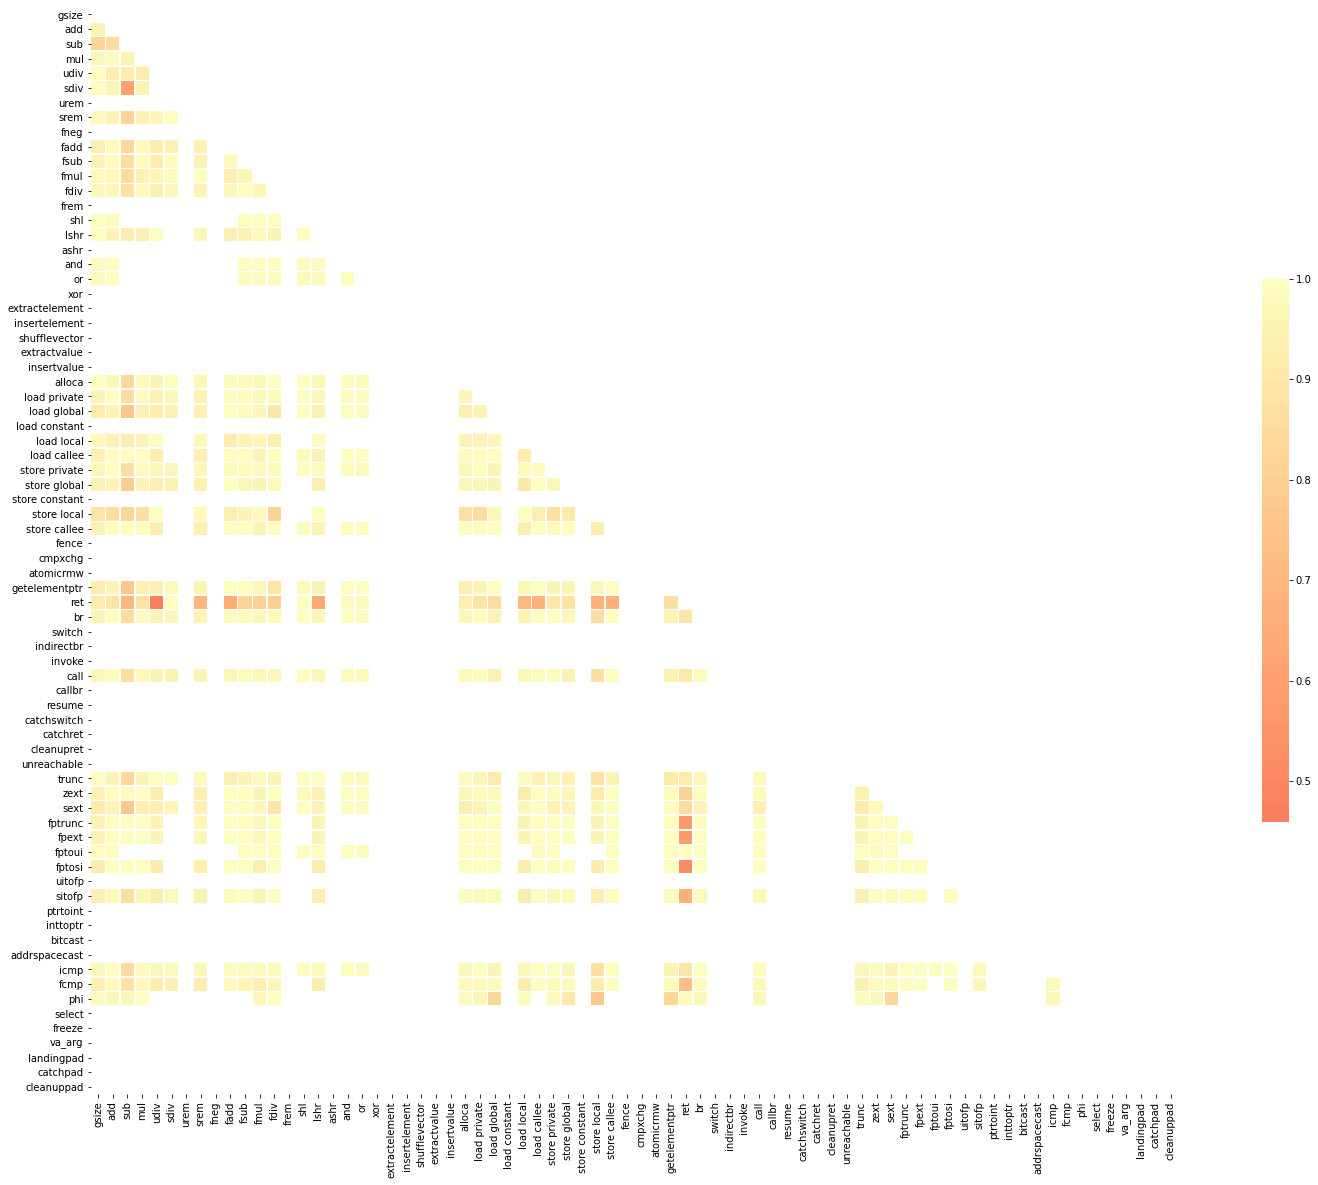

In [16]:
_ = average_correlation_heatmap(relatively_slow_dfs)

We see once again that the correlation between gsize and the executed instructions, as well as between the executed instructions themselves are really strong. Therefore, the answer regarding the slowness of these kernels will probably not be found here; we expect linear or near-linear relations again.

Let's take a closer look, the way we did before:

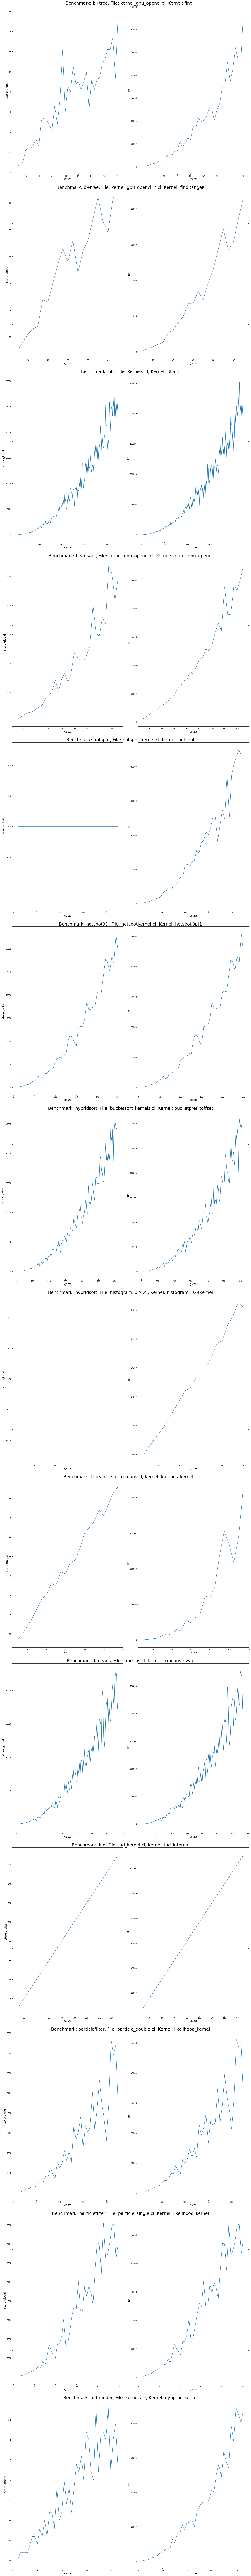

In [17]:
plot_2_instructions_multiple_kernels(
    relatively_slow_info, relatively_slow_dfs, (20, 200),
    'store global', 'br'
)

Things are way more interesting than we expected. First of all, it should be noted that we now have **way fewer profilings compared to what we had from the "relatively fast" kernels**, due to their slowness. This is the main reason for the graphs not being so smooth now. But, even with these few samples, we can make some really important observations:

1. **Almost all the "relatively slow" kernels seem to exhibit a superlinear behavior**. This is not very visible because of the small number of profilings, but it is clearly observable in the `bfs`, `hotspot3D` and `kmeans` amongst others.
2. There is **one kernel, the one from the `lud` benchmark, that exhibits linear behavior**. Observe, though, that we get a really big count for the `br` instruction - around 100000 - with gsize being as small as 130. This explains why `lud`, despite exhibiting a linear behavior, belongs to the "relatively slow" group.

Most probably, the reason this superlinear behavior did not appear in the correlation heatmap above is the very small number of profilings.

### 2.4 Comparative conclusions

Let's draw one last pie chart:

In [18]:
labels = 'relatively fast (or approximately linear)', 'relatively slow (or approximately superlinear)'
values = relatively_fast_kernels, relatively_slow_kernels
colors = 'green', 'orange'

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    marker=dict(colors=colors)
)])

fig.update_layout(
    title=dict(
        text='Grouping of "profilable" rodinia OpenCL kernels',
        font=dict(
            family='Courier New, monospace',
            size=22
        ),
        x=.5
    ),
    font=dict(
        family='Courier New, monospace',
        size=12
    )
)
fig.show()

We concluded that:

- **64.1% of the "profilable" kernels exhibit linear behavior**. This explains their fastness and means that we expect linear regression models to be more accurate than other, more complicated models.
- **35.9% of the "profilable" kernels exhibit superlinear behavior**. This explains their slowness and means that more complicated regression models than the linear ones will be needed. But, given that most kernels of this kind **most probably seem to exhibit a quadratic behavior**, a polynomial model of the appropriate degree may suffice. We must always keep in mind that the profilings are very few and thus very noisy, though, so any conclusion regarding the "relatively slow" kernels should be considered unsafe for now.

Last but (certainly) not least, a secondary but extremely important conclusion is the following:

- It may be the case that **a single regression model won't be accurate enough for the whole benchmark suite**. There will most probably be a single linear regression model that will be very accurate for the "relatively fast" kernels alone, but it is quite uncertain whether:
 1. a global one
 2. one for the "relatively slow" kernels alone

 will (or can) be found.

### 2.5 In defence of the (large) number of samples for the same gsize and why it is essential

As a goodbye and a thank you for staying with me until now, we will wrap up the investigative analysis with a reference to the `-s/--samples` flag of `oclude` and the importance it had in the analysis so far.

First of all, let's profile a kernel for 100 different gsizes, and for different sample sizes:

In [19]:
# profile the same kernel with the same parameters but for increasing number of samples and see what happens

from oclude import profile_opencl_kernel

gsizes = np.arange(50, 5001, 50, dtype=int).tolist()
samples = np.geomspace(1, 100, 3, dtype=int).tolist() + [500]

args = dict(
    file       = os.path.join(os.pardir, 'tests', 'rodinia_kernels', 'particlefilter', 'particle_single.cl'),
    kernel     = 'normalize_weights_kernel',
    instcounts = True,
    timeout    = 0 # do not timeout
)

profs = [] # will be list of lists

for s in samples:
    args['samples'] = s
    profs_for_s = []
    for g in gsizes:
        args['gsize'] = g
        profs_for_s.append(profile_opencl_kernel(**args))
    profs.append(profs_for_s)

[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 50
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: 

[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 950
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Ker

[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1750
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Co

[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2650
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Co

[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3550
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Co

[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4300
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Co

[hostcode] Collecting instruction counts...
[hostcode] Kernel run completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4850
[hostcode] Number of executions (a.k.a. samples) to perform: 1
[hostcode] Co

[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 250
[hostcode] Number of executions (a.k.a. samples) to perform: 10
100%|██████████| 10/10 [00:00<00:00, 274.63 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL

100%|██████████| 10/10 [00:00<00:00, 226.82 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 700
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 10/10 [00:00<00:00, 238.91 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1150
[hostcode] Number of executions (a.k.a. samples) to pe

100%|██████████| 10/10 [00:00<00:00, 210.29 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1600
[hostcode] Number of executions (a.k.a. samples) to pe

100%|██████████| 10/10 [00:00<00:00, 137.43 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2050
[hostcode] Number of executions (a.k.a. samples) to pe

100%|██████████| 10/10 [00:00<00:00, 181.61 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2500
[hostcode] Number of executions (a.k.a. samples) to pe

100%|██████████| 10/10 [00:00<00:00, 89.53 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2950
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 10/10 [00:00<00:00, 94.43 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3400
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 10/10 [00:00<00:00, 92.87 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3850
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 10/10 [00:00<00:00, 78.64 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4300
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 10/10 [00:00<00:00, 66.24 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4750
[hostcode] Number of executions (a.k.a. samples) to per

100%|██████████| 100/100 [00:00<00:00, 374.64 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 200
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 100/100 [00:00<00:00, 333.46 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 650
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 100/100 [00:00<00:00, 200.63 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1100
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 100/100 [00:00<00:00, 236.82 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1550
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 100/100 [00:00<00:00, 143.55 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2000
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 100/100 [00:00<00:00, 144.47 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2450
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 100/100 [00:01<00:00, 97.03 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2900
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 100/100 [00:00<00:00, 140.62 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3350
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 100/100 [00:01<00:00, 93.85 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3800
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 100/100 [00:01<00:00, 88.50 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4250
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 100/100 [00:01<00:00, 74.55 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4700
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 500/500 [00:00<00:00, 570.05 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 150
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 500/500 [00:01<00:00, 424.43 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 600
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 500/500 [00:02<00:00, 213.23 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1050
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:02<00:00, 245.50 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1500
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:02<00:00, 171.96 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 1950
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:03<00:00, 164.17 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2400
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:03<00:00, 127.92 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 2850
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:06<00:00, 79.48 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3300
[hostcode] Number of executions (a.k.a. samples) to p

100%|██████████| 500/500 [00:05<00:00, 96.33 kernel executions/s] 
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 3750
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:05<00:00, 98.72 kernel executions/s] 
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4200
[hostcode] Number of executions (a.k.a. samples) to 

100%|██████████| 500/500 [00:07<00:00, 71.01 kernel executions/s]
[hostcode] Kernel runs completed successfully
[oclude] INFO: Input file ../tests/rodinia_kernels/particlefilter/particle_single.cl is cached
[oclude] INFO: Using cached instrumented file
[oclude] Running kernel 'normalize_weights_kernel' from file ../tests/rodinia_kernels/particlefilter/particle_single.cl
[hostcode] Using the following device:
[hostcode] Platform:	Intel(R) OpenCL HD Graphics
[hostcode] Device:	Intel(R) Gen9 HD Graphics NEO
[hostcode] Version:	OpenCL 2.1 NEO
[hostcode] Kernel name: normalize_weights_kernel
[hostcode] Kernel arg 1: weights (float*, global)
[hostcode] Kernel arg 2: Nparticles (int, private)
[hostcode] Kernel arg 3: partial_sums (float*, global)
[hostcode] Kernel arg 4: CDF (float*, global)
[hostcode] Kernel arg 5: u (float*, global)
[hostcode] Kernel arg 6: seed (int*, global)
[hostcode] About to execute kernel with Global NDRange = 4650
[hostcode] Number of executions (a.k.a. samples) to p

Now, let's plot the above profiling data in an interesting manner:

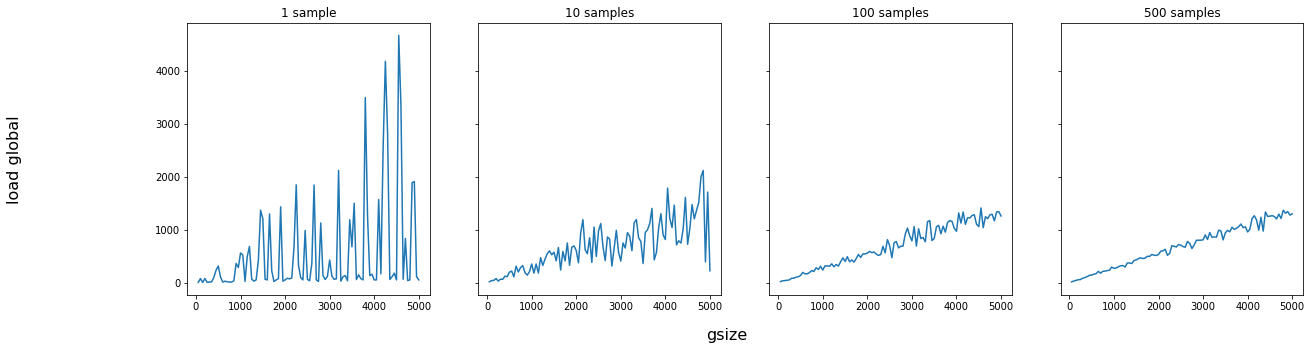

In [20]:
averaged_profs = [get_average_instcounts_dicts(prof) for prof in profs]

INST = 'load global'

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))
fig.text(.5, 0, 'gsize', ha='center', fontsize=16)
fig.text(0, .5, INST, va='center', rotation='vertical', fontsize=16)

for i, s in enumerate(samples):
    instcounts = [x['results']['instcounts'][INST] for x in averaged_profs[i]]
    ax[i].plot(gsizes, instcounts)
    ax[i].set_title(str(s) + ' sample' + ('s' if s > 1 else ''))
    
plt.show()

We can clearly see that **the more samples there are, the less influential the randomness that comes from the initialization of the kernel arguments becomes**.

In the example above, it is obvious that the linear nature of the kernel is not visible at all when we get a single sample. What's more, it seems like we have to deal with greater instruction counts than in reality (i.e. there are a lot of spikes that reach values greater than 2000). But when we start to increase the number of samples (and calculate the average instruction counts), the more visible and obvious it becomes that:

1. the kernel exhibits a linear behavior, and
2. the actual instruction counts are much smaller on average (i.e. the spikes/outliers have been neutralized).